In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, neurons):
        super(PINN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, neurons))
        layers.append(nn.Tanh())
        for _ in range(hidden_layers):
            layers.append(nn.Linear(neurons, neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(neurons, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [3]:
def compute_pde_residuals_nlse(model, x, t, P, Q):
    inputs = torch.cat((x, t), dim=1)
    psi = model(inputs)  # Real and imaginary parts of wave function
    real_psi, imag_psi = psi[:, 0:1], psi[:, 1:2]

    # Compute derivatives
    psi_t = torch.autograd.grad(real_psi, t, torch.ones_like(real_psi), create_graph=True)[0]
    psi_xx = torch.autograd.grad(real_psi, x, torch.ones_like(real_psi), create_graph=True)[0]
    psi_xx = torch.autograd.grad(psi_xx, x, torch.ones_like(psi_xx), create_graph=True)[0]

    # Residuals
    residual_real = psi_t + P * psi_xx + Q * (real_psi**2 + imag_psi**2) * real_psi
    residual_imag = psi_t + P * psi_xx + Q * (real_psi**2 + imag_psi**2) * imag_psi
    return residual_real, residual_imag

def compute_pde_residuals_swe(model, x, t, g):
    inputs = torch.cat((x, t), dim=1)
    eta_u = model(inputs)  # eta (wave height) and u (velocity)
    eta, u = eta_u[:, 0:1], eta_u[:, 1:2]

    # Compute derivatives
    eta_t = torch.autograd.grad(eta, t, torch.ones_like(eta), create_graph=True)[0]
    eta_x = torch.autograd.grad(eta, x, torch.ones_like(eta), create_graph=True)[0]
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]

    # Residuals
    res_eta = eta_t + u * eta_x
    res_u = u_t + u * u_x + g * eta_x
    return res_eta, res_u


In [4]:
# Define spatial and temporal domains
L = 100.0
T = 50.0
x_nlse = torch.linspace(-L / 2, 0, 100)
t_nlse = torch.arange(0, T, 0.1)
x_swe = torch.linspace(0, L / 2, 100)
t_swe = torch.arange(0, T, 0.1)

# Combine points
x_train_nlse = torch.cartesian_prod(x_nlse, t_nlse).requires_grad_(True)
x_train_swe = torch.cartesian_prod(x_swe, t_swe).requires_grad_(True)

# Loss function
def loss_fn_nlse(model, x, t, P, Q):
    res_real, res_imag = compute_pde_residuals_nlse(model, x, t, P, Q)
    loss_residual = torch.mean(res_real**2 + res_imag**2)
    return loss_residual

def loss_fn_swe(model, x, t, g):
    res_eta, res_u = compute_pde_residuals_swe(model, x, t, g)
    loss_residual = torch.mean(res_eta**2 + res_u**2)
    return loss_residual


In [5]:
# Model for NLSE
model_nlse = PINN(input_dim=2, output_dim=2, hidden_layers=3, neurons=50)
optimizer_nlse = torch.optim.Adam(model_nlse.parameters(), lr=0.001)

# Model for SWE
model_swe = PINN(input_dim=2, output_dim=2, hidden_layers=3, neurons=50)
optimizer_swe = torch.optim.Adam(model_swe.parameters(), lr=0.001)

# Training loop
epochs = 500
P, Q, g = 1.0, 1.0, 9.81

for epoch in range(epochs):
    # NLSE
    optimizer_nlse.zero_grad()
    loss_nlse = loss_fn_nlse(model_nlse, x_train_nlse[:, 0:1], x_train_nlse[:, 1:2], P, Q)
    loss_nlse.backward()
    optimizer_nlse.step()

    # SWE
    optimizer_swe.zero_grad()
    loss_swe = loss_fn_swe(model_swe, x_train_swe[:, 0:1], x_train_swe[:, 1:2], g)
    loss_swe.backward()
    optimizer_swe.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, NLSE Loss: {loss_nlse.item():.15f}, SWE Loss: {loss_swe.item():.15f}")


Epoch 0, NLSE Loss: 0.003012590110302, SWE Loss: 0.001158836763352
Epoch 100, NLSE Loss: 0.000000787898443, SWE Loss: 0.000000540221492
Epoch 200, NLSE Loss: 0.000000239905830, SWE Loss: 0.000000230822110
Epoch 300, NLSE Loss: 0.000000120518777, SWE Loss: 0.000000127953498
Epoch 400, NLSE Loss: 0.000000074992542, SWE Loss: 0.000000084800853


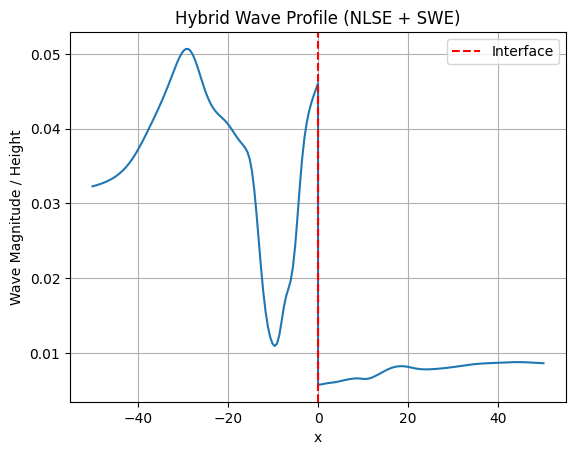

In [26]:
t_query = 12.0


# Query NLSE
x_query_nlse = torch.linspace(-L / 2, 0, 100).reshape(-1,1)
inputs_nlse = torch.cartesian_prod(x_nlse, t_nlse)
output_nlse = model_nlse(inputs_nlse).detach().numpy()
real_psi, imag_psi = output_nlse[:, 0], output_nlse[:, 1]
wave_magnitude_nlse = np.sqrt(real_psi**2 + imag_psi**2)

# Query SWE
x_query_swe = torch.linspace(0, L / 2, 100).reshape(-1,1)
inputs_swe = torch.cartesian_prod(x_swe, t_swe)
output_swe = model_swe(inputs_swe).detach().numpy()
eta_swe = output_swe[:, 0]
eta_swe_v = output_swe[:, 1]


# Find indices where t == t_query
idx_nlse = (inputs_nlse[:, 1] == t_query).nonzero(as_tuple=True)[0]

# Extract corresponding spatial points
x_nlse_t = inputs_nlse[idx_nlse, 0]

# Extract corresponding wave magnitudes
wave_nlse_t = wave_magnitude_nlse[idx_nlse]



# Find indices where t == t_query
idx_swe = (inputs_swe[:, 1] == t_query).nonzero(as_tuple=True)[0]

# Extract corresponding spatial points
x_swe_t = inputs_swe[idx_swe, 0]

# Extract corresponding wave magnitudes
eta_swe_t = eta_swe[idx_swe]
eta_swe_v_t = eta_swe_v[idx_swe]


# Combine results for visualization
x_combined = np.concatenate([x_query_nlse, x_query_swe])
wave_combined = np.concatenate([wave_nlse_t, eta_swe_t])

# Plot hybrid wave profile
plt.plot(x_combined, wave_combined)
plt.axvline(0, color='r', linestyle='--', label="Interface")
plt.title("Hybrid Wave Profile (NLSE + SWE)")
plt.xlabel("x")
plt.ylabel("Wave Magnitude / Height")
plt.grid()
plt.legend()
plt.show()


<ipython-input-14-ce1c006f5e35>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_swe = torch.tensor(x_swe, dtype=torch.float32)
<ipython-input-14-ce1c006f5e35>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eta_swe_t = torch.tensor(eta_swe_t, dtype=torch.float32)
<ipython-input-14-ce1c006f5e35>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eta_swe_v_t = torch.tensor(eta_swe_v_t, dtype=torch.float32)


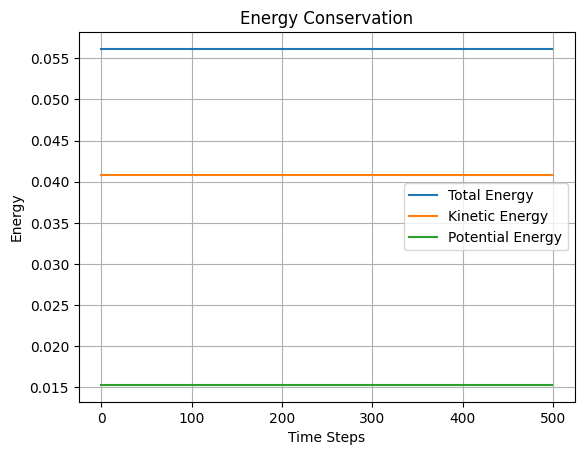

In [14]:
h0 = 10.0  # Initial water depth

# Initialize energy storage
kinetic_energy = []
potential_energy = []
total_energy = []

for t in t_swe:
    # Query SWE predictions

    x_swe = torch.tensor(x_swe, dtype=torch.float32)
    eta_swe_t = torch.tensor(eta_swe_t, dtype=torch.float32)
    eta_swe_v_t = torch.tensor(eta_swe_v_t, dtype=torch.float32)



    eta_t = eta_swe_t  # Replace with actual query logic
    u_t = eta_swe_v_t  # Replace with actual query logic
    h_t = h0 + eta_t




    # Compute dx
    dx = x_swe[1] - x_swe[0]

    # Compute energies
    KE = 0.5 * torch.sum(u_t**2 * h_t) * dx
    PE = 0.5 * g * torch.sum(eta_t**2) * dx

    # Store energies
    kinetic_energy.append(KE.item())
    potential_energy.append(PE.item())
    total_energy.append((KE + PE).item())

# Plot energy conservation
plt.plot(total_energy, label="Total Energy")
plt.plot(kinetic_energy, label="Kinetic Energy")
plt.plot(potential_energy, label="Potential Energy")
plt.title("Energy Conservation")
plt.xlabel("Time Steps")
plt.ylabel("Energy")
plt.legend()
plt.grid()
plt.show()

<ipython-input-28-8f8de1b5d6b2>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_combined = torch.tensor(x_combined, dtype=torch.float32)
<ipython-input-28-8f8de1b5d6b2>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, dtype=torch.float32)


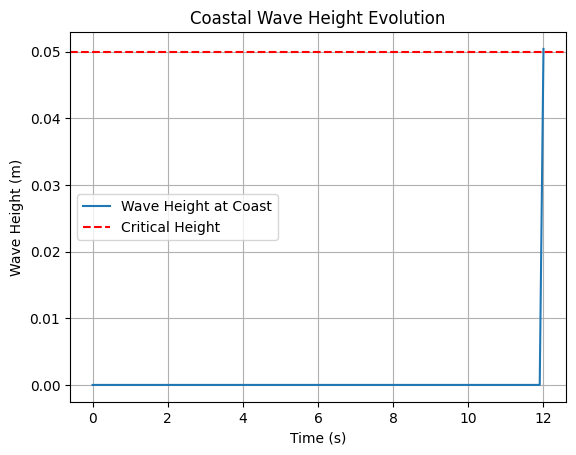

In [28]:
eta_critical = 0.05  # Critical wave height in meters
warning_triggered = False

# Monitor wave height at coastal location (x = 0)
x_coast =  -30 # Coastal location
x_coast = x_combined[torch.abs(x_combined - x_coast).argmin()].item()

coastal_eta = []
coastal_time =[]

for t in t_swe:
    # Query SWE predictions at coastal location
    # y_swe_t = swe_model.predict(np.array([[x_coast, t_swe[t]]]))
    # Conditions
    x_combined = torch.tensor(x_combined, dtype=torch.float32)
    t = torch.tensor(t, dtype=torch.float32)
    condition1 = torch.abs(x_combined - x_coast) < 1e-6
    condition2 = torch.abs(t - t_query) < 1e-6

    # Combine conditions
    condition = condition1 & condition2

    # Find indices where condition is True
    idx_swe = torch.nonzero(condition, as_tuple=True)[0]


    if len(idx_swe) > 0:
        eta_t = wave_combined[idx_swe[0]]  # Wave height at coastal location
        coastal_eta.append(eta_t)
        coastal_time.append(t)

        # Check if threshold is exceeded
        if eta_t > eta_critical:
            print(f"Warning: Critical wave height of {eta_t:.3f} m reached at time {t:.3f} seconds")
            warning_triggered = True
            break
    else:
        coastal_eta.append(0)  # Default value if no match found
        coastal_time.append(t)

if not warning_triggered:
    print("No warning triggered during simulation.")

# Plot wave height at coast
plt.plot(coastal_time, coastal_eta, label="Wave Height at Coast")
plt.axhline(y=eta_critical, color='r', linestyle='--', label="Critical Height")
plt.title("Coastal Wave Height Evolution")
plt.xlabel("Time (s)")
plt.ylabel("Wave Height (m)")
plt.legend()
plt.grid()
plt.show()